## Mécatroniques Mines Paristech 

Groupe 4

Nous allons utiliser le ConvNet construit par Google et notamment François Chollet : [Papier d'origine](https://arxiv.org/abs/1610.02357)

Le réseau se base sur des modules, que l'on présente ci-dessous : 

![inception-module](inception-module.png "Module Inception V3")

Chacun de ces modules vont "s'empiler" pour former notre réseau total. On présente sa forme complète ci-dessous : 

![xception](xception.png "Xception ConvNet")

C'est un réseau qui obtient de très bonnes performances, tout en limitant son nombre de paramètres (22 millions de paramètres). 

![xception-resultats](xception-resultats.png "Xception ConvNet")

## Mise en place du modèle : 

Nous allons commencer par mettre en place nos ConvNet, ainsi que les modules dont nous auront besoin : 

In [42]:
## Imports des différents modules, hors Keras: 
## ===============================

import os
import copy
import sys
import numpy as np
# et pour l'affichage : 

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# Pour Keras : 


from keras import backend as K
from keras import __version__

# Pour charger notre modèle : 
from keras.applications.xception import Xception, preprocess_input
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from keras.models import Model
from keras.models import load_model

# Pour modifier notre modèle : 

from keras.layers import Dense, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, Input, Flatten, Dropout
from keras.optimizers import SGD

# Pour modifier nos images et les utiliser : 

from keras.preprocessing.image import ImageDataGenerator
print("done.")

done.


Nous allons maintenant configurer les paramètres que nous allons utiliser :  

In [43]:
WIDTH, HEIGHT = 224, 224 #fixed size for InceptionV3
CHANNEL = 3
NB_EPOCHS = 50
BAT_SIZE = 24
FC_SIZE = 1024
NB_IMG_TRAIN = 414
NB_IMG_VAL = 53
BAT_SIZE_TEST = 4


nb_classes = 5
print("done.")

done.


On peut maintenant charger notre modèle : 

In [66]:
model_xception = MobileNetV2(input_tensor = Input(shape=(WIDTH,HEIGHT,CHANNEL)),
                          weights='imagenet', # On le prend, pre-trained sur imagesnet. 
                          include_top=False) # Pour enlever la couche Dense(1000) de classification
print("done.")

done.


On va maintenant construire nos fonctions pour le transfer learning. 

Globalement, cela représente : 

- une fonction pour modifier notre réseau (changer les dernières couches)
- une fonction pour freeze l'entrainement de toutes les couches, sauf la dernière
- une fonction pour freeze l'entrainement d'une nombre choisit de couches (fine tunning)


In [67]:
"""
On rajoute des nouvelles couches à notre modèle, et on le retourne

"""

def nouvelle_couche(model, nb_classes):
    x = model.output
    x = AveragePooling2D((2,2), padding='valid')(x) # On place un avg_pooling de taille 10x10 pour limiter les paramètres
    x = Dropout(0.7)(x) # On place du dropout, pour éviter l'overfitting.
    x = Flatten()(x) 
    x = Dense(256,activation='relu')(x)
    x = Dropout(0.7)(x)
    predictions = Dense(nb_classes, activation='softmax')(x)
    new_model = Model(inputs=model.input, outputs=predictions)
    return new_model

print("done.")

done.


In [68]:
"""
On freeze l'intégralité des couches de notre premier modèle : ici le xception.
On compile ensuite notre modèle total et on affiche sa structure.
On renvoie aussi le nombre de couches.
"""

def freeze_full(new_model, model): 
    print("Nombre de couche dans le modèle de base := {}".format(len(model.layers)))
    cpt = 0
    for layer in model.layers:
        layer.trainable = False
        cpt +=1
    print(cpt)
    new_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    new_model.summary()
    
print("done.")

done.


In [69]:
"""
Ici, on ne freeze les couches que jusqu'à un certains index : 
"""

def freeze_some(new_model,model,indx):
    cpt = 0
    for layer in model.layers:
        layer.trainable = False
        cpt+=1
        if cpt > indx:
            break 
    new_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    new_model.summary()
    
print("done.")

done.


Il reste maintenant à mettre en place tout notre modèle.
Pour l'instant, on évite des choix de paramètres tricky, et on freeze tout le Xception de départ : 

In [70]:
# On rajoute nos couches à la fin 

model = nouvelle_couche(model_xception, nb_classes)

# On met en place le freeze, jusqu'à la couche 127. 

#freeze_full(model,model_xception)
freeze_some(model,model_xception,137)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

On va utiliser les fonctionnalités de Keras, on énonce d'abord nos différents paramètres : 

In [71]:
## Pour l'entrainement : 
#On limite ces paramètre, comme on travail sur des visages.

# ======================


rotationTrain = 90
width_shiftTrain = 0.2
height_shiftTrain = 0.2
shearTrain = 0.2
zoomTrain = 0.2
flipTrain = True

## Pour les test : 

# ==============

rotationTest = 5 
width_shiftTest = 0.01
height_shiftTest = 0.01
shearTest = 0.01
zoomTest = 0.05
flipTest = True

print("done.")

done.


On peut maintenant créer nos différents [ImageDataGenerator](https://keras.io/preprocessing/image/)
Les data pour les tests et la validation seront les même. 

Cela va aussi permettre de faire face à la petite taille de nos données : chaque image est ainsi modifiée légérement de façon aléatoire.

In [72]:


trainDataGenerator = ImageDataGenerator(
        rotation_range= rotationTrain,
        width_shift_range= width_shiftTrain,
        height_shift_range= height_shiftTrain,
        shear_range= shearTrain,
        zoom_range= zoomTrain,
        rescale=1./255,
        horizontal_flip= flipTrain,
        vertical_flip =  flipTrain,
        brightness_range=[0.1, 0.5],
        fill_mode='nearest')

testDataGenerator = ImageDataGenerator(
        rotation_range= rotationTest,
        width_shift_range= width_shiftTest,
        height_shift_range= height_shiftTest,
        shear_range= shearTest,
        zoom_range= zoomTest,
        rescale=1./255,
        horizontal_flip= flipTest,
        vertical_flip = flipTest,
        fill_mode='nearest')

print("done.")

done.


Les data sont en .zip sur GitHub. 
Elles sont placées en 2 dossiers : un training, et un validation. 
Chacun de ces deux dossiers comprend ensuite 5 dossiers : cut, pas mur, trop mur, mur et terre. 

Ces différents dossiers comprennent les images que nous allons utiliser. 

## On met ici en place les directions pour ces dossiers 

In [73]:


trainImg = '/Users/paulgarnier/Desktop/Files/ChouxFleurs/frames' 
validationImg = '/Users/paulgarnier/Desktop/Files/ChouxFleurs/validation' 

print("done.")

done.


Finalement, on lance nos dataGenerator avec ces images :  

In [74]:

trainGenerator = trainDataGenerator.flow_from_directory(
                    trainImg,
                    target_size=(WIDTH,HEIGHT),
                    batch_size=BAT_SIZE,
                    color_mode='rgb',
                    class_mode='categorical')

testGenerator = testDataGenerator.flow_from_directory(
                    validationImg,
                    target_size=(WIDTH,HEIGHT),
                    batch_size=BAT_SIZE_TEST,
                    color_mode='rgb',
                    class_mode='categorical') 
print("done.")

Found 643 images belonging to 5 classes.
Found 79 images belonging to 5 classes.
done.


## Entraînement du modèle : 

On peut maintenant entrainer le modèle, puis analyser nos résultats. 
On définit tout d'abord le nom de notre modèle pour pouvoir le sauvegarder sur notre ordinateur.

In [75]:
saveName = "mobileNet_cf_v2.model"
print("done.")

done.


In [76]:
## et on lance le training : 
## ========================

history = model.fit_generator(trainGenerator,
                              steps_per_epoch=NB_IMG_TRAIN/BAT_SIZE,
                              epochs=20,
                              validation_data=testGenerator,
                              validation_steps=NB_IMG_VAL/BAT_SIZE_TEST,
                                 verbose=1) 


model.save(saveName)
print("done.")

Epoch 1/20
18/17 [===============================] - 61s 3s/step - loss: 4.2253 - acc: 0.3866 - val_loss: 3.1417 - val_acc: 0.4107
Epoch 2/20
18/17 [===============================] - 44s 2s/step - loss: 2.0632 - acc: 0.4204 - val_loss: 3.2771 - val_acc: 0.6364
Epoch 3/20
18/17 [===============================] - 45s 3s/step - loss: 1.4791 - acc: 0.4488 - val_loss: 1.9805 - val_acc: 0.4727
Epoch 4/20
18/17 [===============================] - 51s 3s/step - loss: 1.3106 - acc: 0.5000 - val_loss: 2.0080 - val_acc: 0.3393
Epoch 5/20
18/17 [===============================] - 49s 3s/step - loss: 1.2742 - acc: 0.5327 - val_loss: 2.8691 - val_acc: 0.4000
Epoch 6/20
18/17 [===============================] - 47s 3s/step - loss: 1.2663 - acc: 0.5483 - val_loss: 1.9292 - val_acc: 0.4182
Epoch 7/20
18/17 [===============================] - 45s 3s/step - loss: 1.1559 - acc: 0.5648 - val_loss: 1.9426 - val_acc: 0.4643
Epoch 8/20
18/17 [===============================] - 48s 3s/step - loss: 1.0111 - a

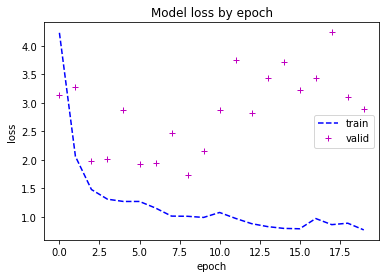

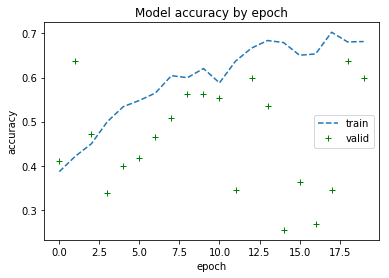

In [77]:
plt.plot(history.history['loss'],'b--')
plt.plot(history.history['val_loss'],'m+')
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')
plt.show()

plt.plot(history.history['acc'],'--')
plt.plot(history.history['val_acc'],'g+')
plt.title('Model accuracy by epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'valid'], loc='right')
plt.xlabel('epoch')
plt.show()


On reload notre modèle pour pouvoir le réutiliser par la suite : 

In [83]:

# MLP for Pima Indians Dataset Serialize to JSON and HDF5
from keras.models import load_model


from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
import numpy
import os

model = load_model("mobileNet_cf_v2.model")

# serialize model to JSON
model_json = model.to_json()
with open("model_small2.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_small2.h5")
print("Saved model to disk")
 
# later...
 
# load json and create model

print("done.")

Saved model to disk
done.


## Test et analyse du modèle : 

In [78]:
## Chemin vers les images pour l'analyse : 
## =======================================
analyse_path = '/Users/paulgarnier/Desktop/Files/ChouxFleurs/test/' 

print("done.")

done.


In [79]:
## Pour display nos images test : 

from keras.preprocessing import image
print("done.")

done.


In [80]:
## Création du tableau : 
## ====================
traine_model = model
data = []

## Ajout des images et des prédictions : 
## =================

for name in os.listdir(analyse_path):
    img_path = analyse_path+name
    if name != ".DS_Store":
        img = image.load_img(path=img_path,grayscale=False,target_size=(224,224,3))
        img_array = image.img_to_array(img)
        img_array /= 255.
        # Prédictions : 
    
        pred = traine_model.predict(np.array([img_array]))
    
        data_image = [img_array,pred,name]
        data.append(data_image)
    
print("done.")

done.


On va maintenant les afficher : 

In [81]:
## On définit ici la fonction qui va permettre d'afficher les images, ainsi qu'un histogramme de probabilité : 

cf = ('cut', 'mur', 'pasmur', 'terre', 'tropmur')
#cf = ('mur','pasmur')
y_pos = np.arange(len(cf))

def display(img,proba,name):
    fig, axes = plt.subplots(2,1)
    
    axIMG = axes[0]
    axPROBA = axes[1]
    
    plt.title(name,loc='right')
    axIMG.imshow(img,aspect=1)
    #proba = np.array(proba)
    axPROBA.barh(y_pos,proba, align='center',color='green')
    axPROBA.set_yticks(y_pos)
    axPROBA.set_yticklabels(cf)
    axPROBA.invert_yaxis()  
    axPROBA.set_xlabel('Probabilité')
    plt.show()

print("done.")

done.


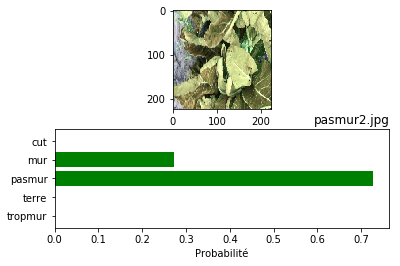

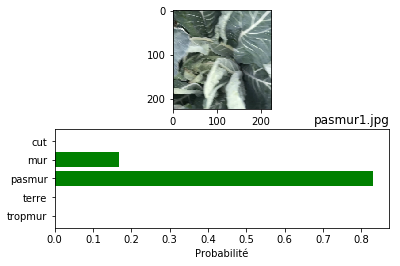

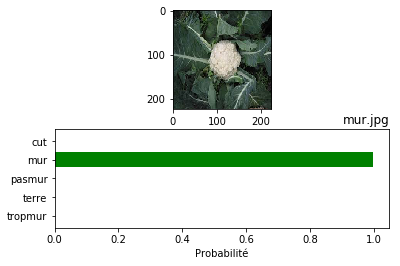

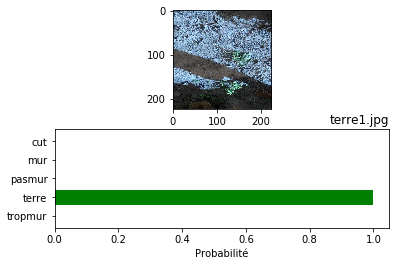

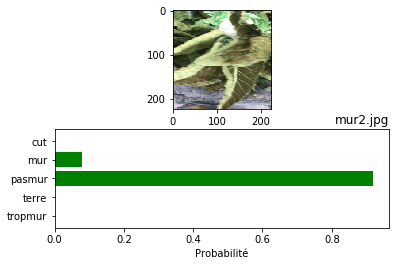

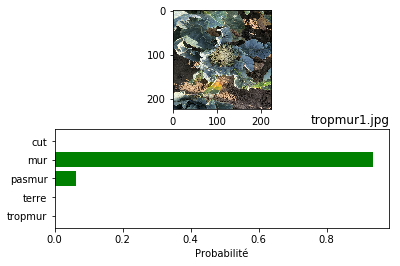

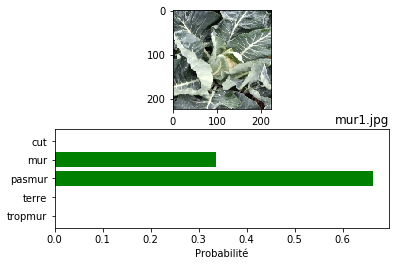

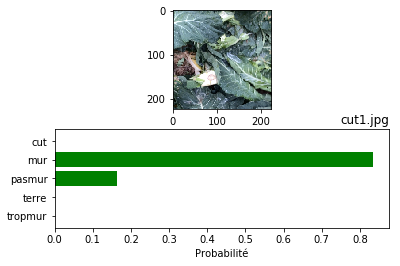

done.


In [82]:
## Display des images : 

for img,proba,title in data:
    
    display(img,proba[0],title)
    
print("done.")